# Supplementary Sage worksheet for article Generalized Pitman-Stanley Polytopes: Vertices and Faces

William T. Dugan, Maura Hegarty, Alejandro H. Morales, Annie Raymond

July 20, 2023, [arXiv:2307.09925](https://arxiv.org/abs/2307.09925)


Generalized Pitman-Stanley polytopes $PS_n^m({\bf a}, {\bf b})$ are defined by:
\begin{align*}
PS^m_n({\bf a},{\bf b}) := \{ & (x_{ij})_{1\leq i\leq n,1\leq j \leq m}  \in \mathbb{R}_{\geq 0}^{n\times m} \quad\big{|} \quad b_1 + \dots + b_i \leq x_{1m}+x_{2m}+\ldots+x_{im} \leq \cdots \\ &\cdots\leq x_{12}+x_{22}+\ldots+x_{i2}\leq  x_{11}+x_{21}+\ldots+x_{i1} \leq a_1 + \dots + a_i \text{ for } i=1,\ldots,n\},
\end{align*}
where ${\bf a}$, ${\bf b} \in {\mathbb N}^n$.

The following code block implements this construction.

In [1]:
def PitmanStanleyPolytope(n,m,a, b=0):
    #n, m are positive integers and a and b are lists of n nonnegative integers 
    nonneg = matrix.identity(n * m + 1)
    IEQs=list()
    for i in range(n*m):
        IEQs.append(list(nonneg[i+1]))
    for i in range(m):
        for j in range(n):
            x = [0]*m
            x[i]=1
            if i+1<m:
                x[i+1]=-1
                next_ieqs = [0]
                y = x*(j+1)
                for k in y:
                    next_ieqs.append(k)
                for k in range(m*(n-j-1)):
                    next_ieqs.append(0)
            else:
                next_ieqs = [sum(a[0:j+1])]
                x[i]=0
                x[0]=-1
                y = x*(j+1)
                for k in y:
                    next_ieqs.append(k)
                for k in range(m*(n-j-1)):
                    next_ieqs.append(0)
            IEQs.append(next_ieqs)
    if b!= 0:
        for i in range(n):
            x = [0]*m
            x[-1]=1
            next_ieqs = [-sum(b[0:i+1])]
            y = x*(i+1)
            for k in y:
                next_ieqs.append(k)
            for k in range(m*(n-i-1)):
                next_ieqs.append(0)
            IEQs.append(next_ieqs)
    return Polyhedron(ieqs=IEQs) #,backend='normaliz')   #<-- Uncomment this line and adjust parentheses if you have normaliz installed for a faster experience.

As an example, we can easily compute the set of integer lattice points in the following way. Note that points are formatted as vectors instead of matrices, with coordinates listed row by row.

In [2]:
PitmanStanleyPolytope(2,3,[1,1]).integral_points() 

((0, 0, 0, 0, 0, 0),
 (0, 0, 0, 1, 0, 0),
 (0, 0, 0, 1, 1, 0),
 (0, 0, 0, 1, 1, 1),
 (0, 0, 0, 2, 0, 0),
 (0, 0, 0, 2, 1, 0),
 (0, 0, 0, 2, 1, 1),
 (0, 0, 0, 2, 2, 0),
 (0, 0, 0, 2, 2, 1),
 (0, 0, 0, 2, 2, 2),
 (1, 0, 0, 0, 0, 0),
 (1, 0, 0, 0, 1, 0),
 (1, 0, 0, 0, 1, 1),
 (1, 0, 0, 1, 0, 0),
 (1, 0, 0, 1, 1, 0),
 (1, 0, 0, 1, 1, 1),
 (1, 0, 0, 1, 2, 0),
 (1, 0, 0, 1, 2, 1),
 (1, 0, 0, 1, 2, 2),
 (1, 1, 0, 0, 0, 0),
 (1, 1, 0, 0, 0, 1),
 (1, 1, 0, 1, 0, 0),
 (1, 1, 0, 1, 0, 1),
 (1, 1, 0, 1, 1, 0),
 (1, 1, 0, 1, 1, 1),
 (1, 1, 0, 1, 1, 2),
 (1, 1, 1, 0, 0, 0),
 (1, 1, 1, 1, 0, 0),
 (1, 1, 1, 1, 1, 0),
 (1, 1, 1, 1, 1, 1))

The following code block implements a class of flow polytopes that allows for non-binary netflow vectors:

In [2]:
from collections import defaultdict 

def elemv(i,n):
        return matrix.identity(n)[i]



class FlowPolytope(Parent):
        
    def __init__(self, g, v):
        """
        g has to be a directed graph
        """
        self.dgraph = g
        self.v = v
        # number of edges
        nume = g.size()
        # number of vertices
        numv = g.order()
        m = matrix.identity(nume+1)
        IEQS = [m[i+1] for i in range(nume)]
        vv = [-i for i in v]
        edgemat = matrix([vv]+[elemv(e[0],numv)-elemv(e[1],numv) for e in g.edges(sort=True)])
        EQS = edgemat.columns()
        #print(IEQS,EQS)
        self.poly = Polyhedron(ieqs=IEQS, eqns=EQS)
    
    def __repr__(self):
        return "Flow polytope: " + self.poly.__repr__() + ", netflow " + str(self.v)
    
    
    def get_int_flows(self):
        LP = self.poly.integral_points()
        IF = []
        E = self.dgraph.edges()
        for p in LP:
            currD = {(E[i][0],E[i][1]):p[i] for i in range(len(p))}
            #currD = defaultdict(int)
            #for i in range(len(p)):
            #    currD[(E[i][0],E[i][1])] = p[i]
            IF.append(currD)
        return IF
        
    def get_int_flows_graph(self):
        LP = self.get_int_flows()
        IF = []
        E = self.dgraph.edges()
        for currD in LP:
            currG = self.dgraph.copy()
            for edge in currG.edges():
                currG.set_edge_label(edge[0],edge[1],currD[(edge[0],edge[1])])
            IF.append(currG)
        return IF
    
    
    def getNetflow(self):
        return self.v
    
    def getGraph(self):
        return self.dgraph
    
    def getPolytope(self):
        return self.poly
    
    def getVolume(self):
        return self.poly.volume(measure='induced_rational',engine = 'latte')*factorial(self.poly.dim())
    
    
    def getVertices(self):
        return self.poly.vertices()



Theorem 3.4 gives an integral equivalence between $PS_n^m({\bf a}, {\bf b})$ and a flow polytope over a grid graph $\mathcal{F}_{G(n,m)}({\bf a}, {\bf b})$. The following code implements the graph $G'(n,m)$, which corresponds to the case that ${\bf b} = {\bf 0}$.  See Figure 2(a) on p. 6 of the paper.

In [3]:
def PitmanStanleyGraph(n, m):
    #n, m are natural numbers
    g = graphs.GridGraph([n, m])
    edges = list(g.edges(sort=True))
    for i in range(m):
        edges.append(((n-1, i), (n, m), None))
    for i in range(n):
        edges.append(((i, m-1), (n, m), None))
    return DiGraph(edges, multiedges=True)

Let us look at an example of the integral equivalence:

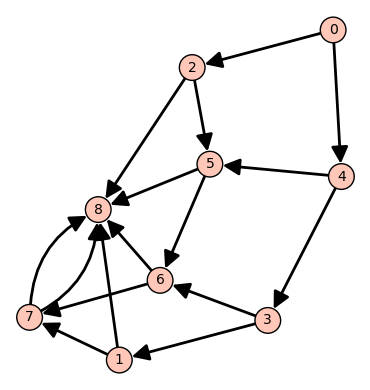

In [13]:
G = PitmanStanleyGraph(2,4)
G = G.canonical_label()  #We need to convert to the canonical labelling in order to input a netflow vector.
show(G)

In [14]:
F = FlowPolytope(G, (3,0,1,0,0,0,0,0,-4))
F

Flow polytope: A 8-dimensional polyhedron in QQ^16 defined as the convex hull of 35 vertices, netflow (3, 0, 1, 0, 0, 0, 0, 0, -4)

In [9]:
P1 = F.getPolytope()
P1.ehrhart_polynomial()

72/5*t^8 + 447/5*t^7 + 4753/20*t^6 + 42383/120*t^5 + 38497/120*t^4 + 7289/40*t^3 + 7577/120*t^2 + 731/60*t + 1

In [10]:
P2 = PitmanStanleyPolytope(2,4,[3,1],[0,0])
P2

A 8-dimensional polyhedron in QQ^8 defined as the convex hull of 35 vertices (use the .plot() method to plot)

In [12]:
P2.ehrhart_polynomial()

72/5*t^8 + 447/5*t^7 + 4753/20*t^6 + 42383/120*t^5 + 38497/120*t^4 + 7289/40*t^3 + 7577/120*t^2 + 731/60*t + 1

In Section 5 of the paper, we demonstrate how the generating functions $\sum_{m \geq 0}v^{(n,m)}x^m$ may be computed using the *transfer matrix method*. Here we illustrate this approach.

In [4]:
#Function to take an integer n specifying a block [1,0,0,0,...,0] of length n, and return the list of all 
#shifted blocks [0,0,...0,1,0,...0], with k prepended 0's and the zero vector:
def shift(n,k):
    A = identity_matrix(n)
    list_return = [tuple([0]*k + list(A.columns()[i]) )for i in range(len(A.columns()))] + [tuple([0]*(n+k))]
    return(list_return)

def flatten(tuple_of_tuples):
    return([element for tupl in tuple_of_tuples for element in tupl]  )

#Takes a tuple of 1's and 0's and returns a list of all neihboring tuples (as a directed graph).
def neighbors_of_v(a):
    indices_of_ones = [i for i,j in enumerate(a) if j == 1]
    #If a is the all-0's vector, return itself:
    if(len(indices_of_ones) == 0):
        return([a])
    else:
        #Compute block sizes:
        block_sizes = [indices_of_ones[i+1] - indices_of_ones[i] for i in range(len(indices_of_ones) - 1)] + [len(a) - indices_of_ones[len(indices_of_ones)-1]]
        #Compute blocks:
        blocks = [shift(block_sizes[0], indices_of_ones[0])] + [shift(j,0) for j in block_sizes[1:]]
        list_to_return = list(cartesian_product(blocks))
        list_to_return = [tuple(flatten(i)) for i in list_to_return]
        return(list_to_return)
    
#Takes an integer n and returns the directed graph on 2^n vertices which we will use for the transfer
#matrix method.
def transfer_graph(n): 
    #Create vertices:
    V = list(cartesian_product([[0,1]]*n))
    #Create dictionary of vertices with edges:
    graph_dict = {v:neighbors_of_v(v) for v in V}
    G = DiGraph(graph_dict, loops = True)
    return(G)

We give an example of Corollary 5.29 from the paper: 


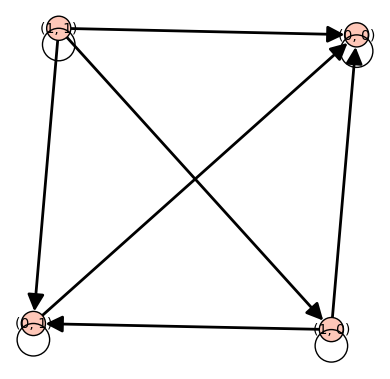

In [6]:
G = transfer_graph(2)
show(G)

In [10]:
A = G.adjacency_matrix()
A

[1 0 0 0]
[1 1 0 0]
[1 1 1 0]
[1 1 1 1]

In [9]:
I = identity_matrix(4)
B = I - x*A
B

[-x + 1      0      0      0]
[    -x -x + 1      0      0]
[    -x     -x -x + 1      0]
[    -x     -x     -x -x + 1]

In [11]:
#Compute the denominator:
den = B.determinant().factor()
den

(x - 1)^4

In [12]:
#Compute the cofactor:
C = B[1:4, 0:3]
C

[    -x -x + 1      0]
[    -x     -x -x + 1]
[    -x     -x     -x]

In [13]:
#Compute the numerator. We multiply by negative 1 per Corollary 5.29: 
num = (-1)*C.determinant().factor()
num

x

In [14]:
#Hence the generating function is:
f = num/den
f

x/(x - 1)^4

In [15]:
#...and expanded as a series:
f.series(x ==0, 10)

1*x + 4*x^2 + 10*x^3 + 20*x^4 + 35*x^5 + 56*x^6 + 84*x^7 + 120*x^8 + 165*x^9 + Order(x^10)

In [24]:
#We can compare to see how this agrees with vertices of the generalized Pitman-Stanley polytope for
#n = 3, a = (1,1,1), b = (0,0,0), and varying m.
[len(PitmanStanleyPolytope(3,m,[1,1,1]).vertices()) for m in range(9)]

[1, 8, 34, 106, 273, 616, 1260, 2388, 4257]

The following code computes the polynomials $v^{(n,m)}({\bf a},{\bf b})$ of the number of vertices pf $PS^n_m({\bf a},{\bf b})$ using polynomial interpolation of $m$. This is slow for $n\geq 5$. For ${\bf b}={\bf 0}$, it is better to use the transfer\-matrix method above.



In [8]:
var('m')
var('k')
R = PolynomialRing(QQ,'x')

# d is the degre of the polynomial 
def get_poly_vertices(a,b,d,nz=0):
    n = len(a)
    L = [(m,len(PitmanStanleyPolytope(n,m,a,b).vertices())) for m in range(1,d-1)]+[(0,1),]
    ff = R.lagrange_polynomial(L)
    return ff


def get_poly_vertices_list(a,b,d):
    n = len(a)
    L = [[m,len(PitmanStanleyPolytope(n,m,a,b).vertices())] for m in range(1,d)]
    return L

In [12]:
f = get_poly_vertices([1,1,1],[0,0,1],5)
f

31/6*x^3 - 4*x^2 + 41/6*x + 1